In [1]:
import random
import numpy as np
import os

np.random.seed(1143583)

def get_random_list(num, start, end):
    random.seed(1143583)
    selected_idx = random.sample(range(start, end), num)
    return sorted(selected_idx)

def train_test_split(input_list):
    train_idx = get_random_list(int(len(input_list) * 0.7), 0, len(input_list))
    train_list = [input_list[i] for i in train_idx]
    test_list = [input_list[i] for i in range(len(input_list)) if i not in train_idx]
    return train_list, test_list

# Choose 25  subjects
selected_idx = get_random_list(25, 1, 68)
print('Selected subjects:', selected_idx)

NUM_IMG_PER_SUBJ = 170
NUM_Self = 10

# List of paths to PIE images
pie_list = [os.path.join('PIE', str(subj_idx), f'{i + 1}.jpg') for subj_idx in selected_idx for i in range(NUM_IMG_PER_SUBJ)]
selfies_list = [os.path.join('selfies', 'formatted', f'{i + 1}.jpg') for i in range(NUM_Self)]

# List of paths to all images of interest
list_of_img_end_paths = pie_list + selfies_list

print('Number of selected PIE images:', len(pie_list))
print('Number of selected selfies:', len(selfies_list))

# Split PIE and selfies train and test
pie_train_list, pie_test_list = train_test_split(pie_list)
selfies_train_list, selfies_test_list = train_test_split(selfies_list)

Selected subjects: [1, 4, 6, 10, 14, 16, 17, 18, 19, 21, 23, 26, 27, 28, 34, 36, 44, 47, 48, 52, 54, 56, 60, 64, 65]
Number of selected PIE images: 4250
Number of selected selfies: 10


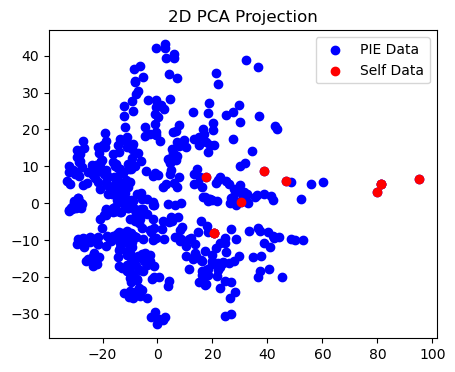

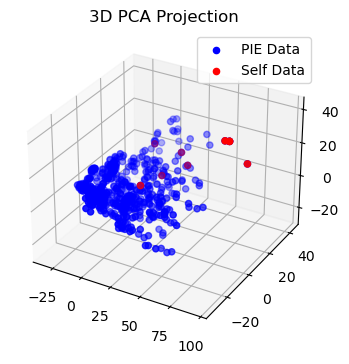

In [2]:
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# path of data
pie_path = r'D:\University\NUS\EE5907\PIE'
self_path = r'D:\University\NUS\EE5907\self'

np.random.seed(1143583)

data = []
labels = []

# load 500 pictures
count = 0
for subject_folder in os.listdir(pie_path):
    subject_path = os.path.join(pie_path, subject_folder)
    if os.path.isdir(subject_path):
        for image_file in os.listdir(subject_path):
            if count >= 500:
                break
            image_path = os.path.join(subject_path, image_file)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            img_flat = img.flatten()
            data.append(img_flat)
            labels.append(subject_folder)
            count += 1

# load myself pictures
for image_file in os.listdir(self_path):
    image_path = os.path.join(self_path, image_file)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_flat = img.flatten()
    data.append(img_flat)
    labels.append("self")


data = np.array(data)
labels = np.array(labels)


data_standardized = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

cov_matrix = np.cov(data_standardized.T)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

eigenvalues = eigenvalues.real
eigenvectors = eigenvectors.real

top_eigenvectors_2d = eigenvectors[:, :2]
top_eigenvectors_3d = eigenvectors[:, :3]
data_pca_2d = np.dot(data_standardized, top_eigenvectors_2d)
data_pca_3d = np.dot(data_standardized, top_eigenvectors_3d)

self_indices = np.where(labels == "self")[0]

# plot 2D
plt.figure(figsize=(5, 4))
plt.scatter(data_pca_2d[:, 0], data_pca_2d[:, 1], c='b', label='PIE Data')
plt.scatter(data_pca_2d[self_indices, 0], data_pca_2d[self_indices, 1], c='r', label='Self Data')
plt.title('2D PCA Projection')
plt.legend()
plt.show()

# plot 3D
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_pca_3d[:, 0], data_pca_3d[:, 1], data_pca_3d[:, 2], c='b', label='PIE Data')
ax.scatter(data_pca_3d[self_indices, 0], data_pca_3d[self_indices, 1], data_pca_3d[self_indices, 2], c='r', label='Self Data')
ax.set_title('3D PCA Projection')
ax.legend()
plt.show()


In [3]:
data = []
labels = []

count = 0
for subject_folder in os.listdir(pie_path):
    subject_path = os.path.join(pie_path, subject_folder)
    if os.path.isdir(subject_path):
        for image_file in os.listdir(subject_path):
            if count >= 500:
                break
            image_path = os.path.join(subject_path, image_file)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            img_flat = img.flatten()
            data.append(img_flat)
            labels.append(subject_folder)
            count += 1

for i in range(1, 10):  
    image_path = os.path.join(self_path, f"{i}.jpg")
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_flat = img.flatten()
    data.append(img_flat)
    labels.append("self")

data = np.array(data)
labels = np.array(labels)

data_standardized = (data - np.mean(data, axis=0)) / np.std(data, axis=0)


self_indices = np.where(labels == "self")[0]

train_ratio = 0.7
train_size = int(train_ratio * len(data))

indices = np.random.permutation(len(data))
train_indices, test_indices = indices[:train_size], indices[train_size:]

# 
self_indices = np.where(labels[test_indices] == "self")[0]
all_test_indices = np.concatenate([test_indices, self_indices])

X_train, X_test = data_standardized[train_indices], data_standardized[all_test_indices]
y_train, y_test = labels[train_indices], labels[all_test_indices]

# KNN
def k_nearest_neighbors(train_data, train_labels, test_data, test_labels, k=2):
    predictions = []
    for i, test_point in enumerate(test_data):
        distances = np.linalg.norm(train_data - test_point, axis=1)
        nearest_neighbors_indices = np.argsort(distances)[:k]
        nearest_labels = train_labels[nearest_neighbors_indices]
        unique_labels, counts = np.unique(nearest_labels, return_counts=True)
        predicted_label = unique_labels[np.argmax(counts)]
        predictions.append(predicted_label)

    return np.array(predictions)

# 
def accuracy(predictions, true_labels):
    correct = np.sum(predictions == true_labels)
    total = len(true_labels)
    return correct / total

# pca dim
dimensions = [2, 3, 40, 80, 200]

for dim in dimensions:
    # PCA
    cov_matrix = np.cov(X_train.T)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    top_eigenvectors = eigenvectors[:, :dim]
    X_train_pca = np.dot(X_train, top_eigenvectors)
    X_test_pca = np.dot(X_test, top_eigenvectors)

    # Knn
    predictions = k_nearest_neighbors(X_train_pca, y_train, X_test_pca, y_test)
    acc = accuracy(predictions, y_test)
    self_predictions = predictions[-len(self_indices):]
    self_acc = accuracy(self_predictions, y_test[-len(self_indices):])
    
    
    print(f'Accuracy (Dimension={dim}) - CMU PIE Test Images: {acc:.2%}')
    print(f'Accuracy (Dimension={dim}) - Self Test Images: {self_acc:.2%}\n')


Accuracy (Dimension=2) - CMU PIE Test Images: 71.79%
Accuracy (Dimension=2) - Self Test Images: 66.67%

Accuracy (Dimension=3) - CMU PIE Test Images: 82.69%
Accuracy (Dimension=3) - Self Test Images: 100.00%

Accuracy (Dimension=40) - CMU PIE Test Images: 97.44%
Accuracy (Dimension=40) - Self Test Images: 100.00%

Accuracy (Dimension=80) - CMU PIE Test Images: 97.44%
Accuracy (Dimension=80) - Self Test Images: 100.00%

Accuracy (Dimension=200) - CMU PIE Test Images: 97.44%
Accuracy (Dimension=200) - Self Test Images: 100.00%



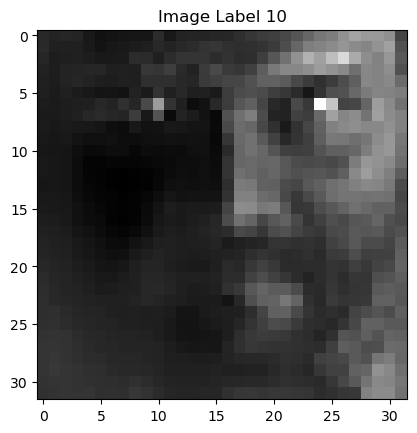

In [4]:
index_10 = np.where(y_train == '10')[0][0]
image_10 = X_train[index_10]

image_10_reshaped = image_10.reshape((32, 32)) 
plt.imshow(image_10_reshaped, cmap='gray')
plt.title('Image Label 10')
plt.show()